#Miller-Tucker-Zemlin (MTZ) Formulation

The **Traveling Salesman Problem (TSP)** may be formulated as an Integer Linear Programming (ILP) model. Below, we develop the well-known Miller-Tucker-Zemlin (MTZ) formulation. Although it is not the most computationally efficient, it is one of the easiest to code.

Label the stops enumerated as $1, 2, \dots, n$, where $n$ is the total number of stops, and arbitrarily assume $1$ as the origin.

Define the decision variables:

$$
x_{ij} = \begin{cases}
1 & \text{if the route includes a direct link between stops } i \text{ and } j \\
0 & \text{otherwise}
\end{cases}
$$

In addition, for each stop $i = 1, 2, \dots, n$, let $u_i \in \mathbb{R}^{+}$ be an auxiliary variable, and let $c_{ij}$ be the distance between stops $i$ and $j$.

The MTZ formulation for the TSP is as follows:

The objective function is given by:

$$
\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij}
$$

To ensure that the result is a valid tour, several constraints must be added.

Subject to:

$$
\sum_{i=1, j=1}^{n} x_{ij} = 1 \quad (1)
$$

$$
\sum_{j=1, j=1}^{n} x_{ij} = 1 \quad (2)
$$

$$
u_i + x_{ij} \leq u_j + (n-1) \times (1 - x_{ij}), \quad 2 \leq j \leq n \quad (3)
$$

$$
u_i \in \mathbb{R}^{+} \quad (4)
$$

$$
x_{ij} \in \{0, 1\} \quad (5)
$$

In the formulation above, notice that:

**Go-to constraints**: The first set of equalities requires that each stop is arrived at from exactly one other stop.\
**Come-from constraints**: The second set of equalities requires that from each stop there is a departure to exactly one next stop.

Notice that these constraints do not guarantee the formation of a single tour encompassing all stops, allowing the formation of subtours.


**Subtour elimination**: The subtour elimination constraints work by labeling the order in which the nodes are visited. Let’s call $u_i$ the rank of each node in the order of visits. Then $(x_{ij} = 1) \implies (u_i + 1 = u_j)$. This constraint is not linear, therefore it is replaced by its big-M equivalent (3).


Besides MTZ constraints, there are several other formulations for the subtour elimination constraint, including circuit packing constraints and network flow constraints.

#For 11 cities

In [1]:
import pandas as pd
city = pd.read_csv("TSP11.csv", header = None)

In [2]:
city

,0,1,2,3,4,5,6,7,8,9,10
0,0,29,20,21,16,31,100,12,4,31,18
1,29,0,15,29,28,40,72,21,29,41,12
2,20,15,0,15,14,25,81,9,23,27,13
3,21,29,15,0,4,12,92,12,25,13,25
4,16,28,14,4,0,16,94,9,20,16,22
5,31,40,25,12,16,0,95,24,36,3,37
6,100,72,81,92,94,95,0,90,101,99,84
7,12,21,9,12,9,24,90,0,15,25,13
8,4,29,23,25,20,36,101,15,0,35,18
9,31,41,27,13,16,3,99,25,35,0,38


In [3]:
import numpy as np

In [4]:
city_arr = np.array(city)
city_arr

array([[  0,  29,  20,  21,  16,  31, 100,  12,   4,  31,  18],
       [ 29,   0,  15,  29,  28,  40,  72,  21,  29,  41,  12],
       [ 20,  15,   0,  15,  14,  25,  81,   9,  23,  27,  13],
       [ 21,  29,  15,   0,   4,  12,  92,  12,  25,  13,  25],
       [ 16,  28,  14,   4,   0,  16,  94,   9,  20,  16,  22],
       [ 31,  40,  25,  12,  16,   0,  95,  24,  36,   3,  37],
       [100,  72,  81,  92,  94,  95,   0,  90, 101,  99,  84],
       [ 12,  21,   9,  12,   9,  24,  90,   0,  15,  25,  13],
       [  4,  29,  23,  25,  20,  36, 101,  15,   0,  35,  18],
       [ 31,  41,  27,  13,  16,   3,  99,  25,  35,   0,  38],
       [ 18,  12,  13,  25,  22,  37,  84,  13,  18,  38,   0]])

In [5]:
num_city = city_arr.shape[0]

In [6]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 26.3 MB/s eta 0:00:00


In [7]:
import pulp

# Number of cities
num_cities = num_city

# Define the problem
problem = pulp.LpProblem("TSP", pulp.LpMinimize)

# Decision Variables
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(num_cities) for j in range(num_cities) if i != j), cat='Binary')

# Auxiliary variables for subtour elimination
u = pulp.LpVariable.dicts("u", (i for i in range(num_cities)), lowBound=1, upBound=num_cities, cat='Continuous')

# Distances matrix (assuming 0-indexed)
distances = city_arr

# Objective Function
problem += pulp.lpSum(distances[i][j] * x[(i, j)] for i in range(num_cities) for j in range(num_cities) if i != j)

# Degree Constraints
for i in range(num_cities):
    problem += pulp.lpSum(x[(i, j)] for j in range(num_cities) if i != j) == 1  # Leave each city once
    problem += pulp.lpSum(x[(j, i)] for j in range(num_cities) if i != j) == 1  # Enter each city once

# Subtour Elimination Constraints (MTZ)
for i in range(1, num_cities):
    for j in range(1, num_cities):
        if i != j:
            problem += u[i] - u[j] + num_cities * x[(i, j)] <= num_cities - 1

# Fix the position of the first city to avoid symmetry
problem += u[0] == 1

# Solve the problem
problem.solve()

# Print the solution
print("Status:", pulp.LpStatus[problem.status])
print("Total Distance:", pulp.value(problem.objective))
for i in range(num_cities):
    for j in range(num_cities):
        if i != j and pulp.value(x[(i, j)]) == 1:
            print(f"Travel from city {i+1} to city {j+1}")



Status: Optimal
Total Distance: 253.0
Travel from city 1 to city 8
Travel from city 2 to city 11
Travel from city 3 to city 7
Travel from city 4 to city 10
Travel from city 5 to city 4
Travel from city 6 to city 3
Travel from city 7 to city 2
Travel from city 8 to city 5
Travel from city 9 to city 1
Travel from city 10 to city 6
Travel from city 11 to city 9


We can see the graph of travel

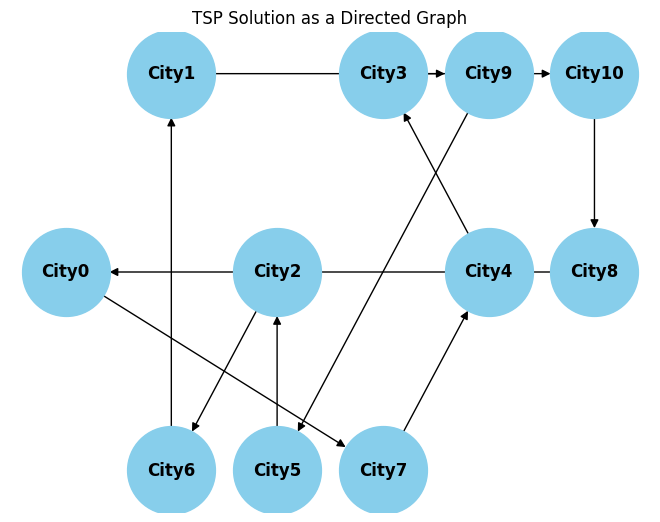

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp

# Assuming 'problem' is your pulp problem instance and 'x' are the decision variables
# Solve the problem again for demonstration
problem.solve()

# Create a directed graph
G = nx.DiGraph()

# Cities and their positions for visualization (You can adjust the positions as needed)
positions = {
    0: (0, 0),
    1: (1, 1),
    2: (2, 0),
    3: (3, 1),
    4: (4, 0),
    5: (2, -1),
    6: (1, -1),
    7: (3, -1),
    8: (5, 0),
    9: (4, 1),
    10: (5, 1)
}

# Add nodes with city names
city_names = {
    0: "City0",
    1: "City1",
    2: "City2",
    3: "City3",
    4: "City4",
    5: "City5",
    6: "City6",
    7: "City7",
    8: "City8",
    9: "City9",
    10:"City10",
}

# Add nodes
for city in positions.keys():
    G.add_node(city)

# Add edges based on the TSP solution
for i in range(11):
    for j in range(11):
        if i != j and pulp.value(x[(i, j)]) == 1:
            G.add_edge(i, j)

# Drawing the graph
nx.draw(G, positions, with_labels=False, node_color='skyblue', node_size=4000,
        arrowstyle='-|>', arrowsize=12, font_size=12, font_weight='bold')

# Add city names as labels
node_labels = {node: city_names[node] for node in G.nodes()}
nx.draw_networkx_labels(G, positions, labels=node_labels, font_size=12, font_color='black', font_weight='bold')

plt.title('TSP Solution as a Directed Graph')
plt.show()


City 0 means city 1, city 1 means city 2. Similarly increase all of them by one.

#For 48 Cities

In [13]:
import pandas as pd
city = pd.read_csv("TSP48.csv", header = None)

In [14]:
city_arr = np.array(city)
city_arr

array([[   0, 4727, 1205, ..., 1542, 2379, 3744],
       [4727,    0, 3588, ..., 5461, 4390, 2088],
       [1205, 3588,    0, ..., 2023, 1867, 2560],
       ...,
       [1542, 5461, 2023, ...,    0, 1644, 3928],
       [2379, 4390, 1867, ..., 1644,    0, 2532],
       [3744, 2088, 2560, ..., 3928, 2532,    0]])

In [15]:
num_city = city_arr.shape[0]

In [ ]:
import pulp

# Number of cities
num_cities = num_city

# Define the problem
problem = pulp.LpProblem("TSP", pulp.LpMinimize)

# Decision Variables
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(num_cities) for j in range(num_cities) if i != j), cat='Binary')

# Auxiliary variables for subtour elimination
u = pulp.LpVariable.dicts("u", (i for i in range(num_cities)), lowBound=1, upBound=num_cities, cat='Continuous')

# Distances matrix (assuming 0-indexed)
distances = city_arr

# Objective Function
problem += pulp.lpSum(distances[i][j] * x[(i, j)] for i in range(num_cities) for j in range(num_cities) if i != j)

# Degree Constraints
for i in range(num_cities):
    problem += pulp.lpSum(x[(i, j)] for j in range(num_cities) if i != j) == 1  # Leave each city once
    problem += pulp.lpSum(x[(j, i)] for j in range(num_cities) if i != j) == 1  # Enter each city once

# Subtour Elimination Constraints (MTZ)
for i in range(1, num_cities):
    for j in range(1, num_cities):
        if i != j:
            problem += u[i] - u[j] + num_cities * x[(i, j)] <= num_cities - 1

# Fix the position of the first city to avoid symmetry
problem += u[0] == 1

# Solve the problem
problem.solve()

# Print the solution
print("Status:", pulp.LpStatus[problem.status])
print("Total Distance:", pulp.value(problem.objective))
for i in range(num_cities):
    for j in range(num_cities):
        if i != j and pulp.value(x[(i, j)]) == 1:
            print(f"Travel from city {i+1} to city {j+1}")

###This part keeps on running. So using heuristic is the best way to get either a sub optimal solution or an optimal solution.